In [2]:
!rm -rf Eunomia
!git clone https://github.com/ouaguenouni/Eunomia
!pip install -r Eunomia/requirements.txt

Cloning into 'Eunomia'...
remote: Enumerating objects: 2887, done.
remote: Counting objects: 100% (2887/2887), done.
remote: Compressing objects: 100% (558/558), done.
remote: Total 2887 (delta 2410), reused 2794 (delta 2317), pack-reused 0
Receiving objects: 100% (2887/2887), 12.88 MiB | 3.62 MiB/s, done.
Resolving deltas: 100% (2410/2410), done.


In [146]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from Eunomia.preferences import *
from Eunomia.additive_functions import *
from Eunomia.alternatives import *
from Eunomia.sampling import *
from Eunomia.mcmc import *
#from Eunomia.degree import *
from Eunomia.experiments import *
from Eunomia.ssb import * 
from Eunomia.graph_utils import * 
from docplex.mp.model import Model
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm, trange
from itertools import combinations
import networkx as nx
pyro.set_rng_seed(1)

In [166]:
def get_all_pairs(L):
    r = []
    for i in range(len(L)):
        for j in range(i+1,len(L)):
            r.append((L[i], L[j]))
    return r

def subsets_up_to_k(L, k):
    """Return all subsets of L with size less than or equal to k."""
    all_subsets = []
    for i in range(0, k + 1):
        for subset in combinations(L, i):
            all_subsets.append(subset)
    return all_subsets


def create_directed_graph(S, f):
    """
    Creates a directed graph from a set S and a binary function f.
    
    Parameters:
    - S: A set of elements.
    - f: A binary function f(x, y) that returns a value for each pair of elements x, y in S.
    
    Returns:
    - A directed graph (nx.DiGraph) where vertices are elements of S, and an arc exists from x to y iff f(x, y) > 0.
    """
    G = nx.DiGraph()
    G.add_nodes_from(S)  # Add each element of S as a vertex in the graph
    
    # Add edges based on the binary function f
    for x in S:
        for y in S:
            if x != y and f(x, y) > 0:
                G.add_edge(x, y)
    
    return G

def longest_circuit_size(G):
    G = ssb_function.get_graph()
    cycles = list(nx.recursive_simple_cycles(G))
    max_size = 0
    longest_circuit = None
    if len(cycles) > 0:
        max_size = max(len(i) for i in cycles)
        for i in cycles:
            if len(i) == max_size:
                longest_circuit = i
    return max_size, longest_circuit

In [176]:
class SSB_Graph:
    
    def __init__(self, items, theta = None, w = None, phi = None):
        if not theta:
            theta = subsets_up_to_k(items, 1)
            theta = [i for i in theta if not len(i) == 0]
        if not w:
            w = {i : np.random.normal(0,3) for i in theta}
        if not phi:
            phi = {i : np.random.normal(0,3) for i in get_all_pairs(theta)}
        self.items = items
        self.theta = theta
        self.w = w
        self.phi = phi
        
    def print_model(self):
        for x in self.theta:
            if self.w[x] != 0:
                print(f"w[{x}] = {self.w[x]}")
        for x,y in self.phi:
            if self.phi[(x,y)] != 0:
                print(f"phi[({x}->{y})] = {self.phi[(x,y)]}")
    
    def __call__(self,x,y):
        v = 0
        for s in self.w:
            if all(i in x for i in s):
                v += self.w[s]
            if all(i in y for i in s):
                v -= self.w[s]
        for A,B in self.phi:
            if all(i in x for i in A) and all(i in y for i in B):
                v += self.phi[(A,B)]
            if all(i in x for i in B) and all(i in y for i in A):
                v -= self.phi[(A,B)]
        return v
            
    def get_graph(self):
        all_subsets = subsets_up_to_k(self.items, len(self.items))
        G = nx.DiGraph()
        G.add_nodes_from(all_subsets)  # Add each element of S as a vertex in the graph
        for x in all_subsets:
            for y in all_subsets:
                if x != y and self(x, y) > 0:
                    G.add_edge(x, y)
        return G

In [177]:
n = 3
items = np.arange(n)
ssb_function=SSB_Graph(items)

In [178]:
ssb_function.print_model()

w[(0,)] = 5.081427339864243
w[(1,)] = 0.5906093377508743
w[(2,)] = 0.5096077660427151
phi[((0,)->(1,))] = -3.4920239134836066
phi[((0,)->(2,))] = 2.0800986769811534
phi[((1,)->(2,))] = -2.2742019856686966


In [179]:
G = ssb_function.get_graph()
longest_circuit_size(G)

(0, None)

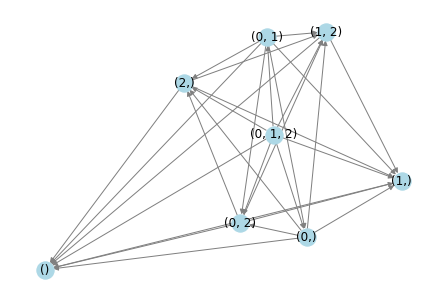

In [180]:
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray')
plt.show()

In [181]:
n = 3
items = np.arange(n)
sizes = []
for iter_ in range(100):
    ssb_function = SSB_Graph(items)
    G = ssb_function.get_graph()
    size, circuit = longest_circuit_size(G)
    sizes.append(size)
    if size == 8:
        print("=========")
        ssb_function.print_model()
        print("=========")
        break


w[(0,)] = 3.9291177170479603
w[(1,)] = -3.464947904788093
w[(2,)] = -0.532896587950653
phi[((0,)->(1,))] = -4.531369125262707
phi[((0,)->(2,))] = 3.033621191324725
phi[((1,)->(2,))] = -4.429687981560541


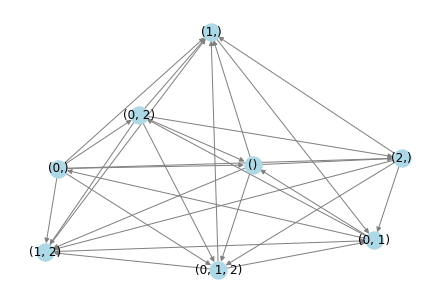

In [182]:
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray')
plt.show()

In [183]:
for i in range(len(circuit)-1):
        print(f"f({circuit[i]}, {circuit[i+1]} =  {ssb_function(circuit[i], circuit[i+1])}")

f((), (2,) =  0.532896587950653
f((2,), (0, 1, 2) =  0.9318969779759483
f((0, 1, 2), (1, 2) =  2.4313697831099788
f((1, 2), (1,) =  3.8967913936098877
f((1,), (0, 1) =  0.6022514082147463
f((0, 1), (0,) =  1.0664212204746137
f((0,), (0, 2) =  3.566517779275378


In [184]:
circuit

[(), (2,), (0, 1, 2), (1, 2), (1,), (0, 1), (0,), (0, 2)]

In [185]:
ssb_function((0,2), tuple([]))

3.3962211290973072